## 0 引言

&emsp;&emsp;星球大战是一部伟大的电影，讲述了一段在遥远的银河发生的故事，对世界流行文化影响深远。[Kaggle](https://www.kaggle.com/) 上有星球大战正传三部曲的剧本，虽然数据量不大，也是一次实现文本分析的有趣尝试。

## 1 导入相关包 

In [1]:
# Jupyter 魔法函数，在当前页面输出图像
%matplotlib inline

In [2]:
# 数据处理及导入导出
import pandas as pd

# 数据可视化基础库
import matplotlib.pyplot as plt
# 更好的可视化效果
import seaborn as sns
sns.set_style("whitegrid") #设置 seaborn 主题

# 词云
from wordcloud import WordCloud  
from imageio import imread

# 机器学习
import gensim #构建 word2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 去除停用词，并将字符串转换成列表
import string
from nltk.corpus import stopwords 
stop = stopwords.words('english') #停用词

E:\IDE\Anaconda3\envs\gaius\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## 2 导入数据

&emsp;&emsp;分别从 3 个 txt 文件中，导入星球大战四、五、六的剧本为数据框（DataFrame）。

In [3]:
# 从 txt 文件中导入数据
SW_IV = pd.read_table('data/SW_EpisodeIV.txt', delim_whitespace=True, header=0, escapechar='\\')
SW_V = pd.read_table('data/SW_EpisodeV.txt', delim_whitespace=True, header=0, escapechar='\\')
SW_VI = pd.read_table('data/SW_EpisodeVI.txt', delim_whitespace=True, header=0, escapechar='\\')

In [4]:
# 查看数据框
SW_IV.sample(10)

,character,dialogue
327,LUKE,What?
84,LUKE,"I know, but he's got enough vaporators going t..."
639,LUKE,There isn't any other way out.
978,VADER,I'm on the leader.
296,BEN,They didn't. But we are meant to think they d...
417,BEN,How long before you can make the jump to light...
488,LUKE,It followed us!
774,LEIA,There are still two more of them out there!
183,OWEN,I told you to forget it. Your only concern is...
287,VADER,The plans you refer to will soon be back in ou...


## 3 数据处理

&emsp;&emsp;在分析之前，先进行简单的数据处理，剔除 `dialogue` 列中的停用词，并将其由字符串转换成列表。

In [5]:
print("停用词表：\n{0}".format(stop))

停用词表：
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'th

In [6]:
def prep_text(series):
    """
        去除停用词，并将字符串转换成列表
        
        Args:
            series: Series
    
        Returns:
            Series
    """
    return series.str.replace('\'', ' ').apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]).lower().translate(str.maketrans("", "", string.punctuation)).split())

In [7]:
SW_IV['clean_text'] = prep_text(SW_IV['dialogue'])
SW_V['clean_text'] = prep_text(SW_V['dialogue'])
SW_VI['clean_text'] = prep_text(SW_VI['dialogue'])

In [8]:
SW_IV.head()

,character,dialogue,clean_text
1,THREEPIO,Did you hear that? They've shut down the main...,"[did, hear, that, they, shut, main, reactor, w..."
2,THREEPIO,We're doomed!,"[we, doomed]"
3,THREEPIO,There'll be no escape for the Princess this time.,"[there, escape, princess, time]"
4,THREEPIO,What's that?,"[what, that]"
5,THREEPIO,I should have known better than to trust the l...,"[i, known, better, trust, logic, halfsized, th..."


&emsp;&emsp;将 3 个数据框进行合并为一个新的数据框。

In [9]:
SW = pd.concat([SW_IV, SW_V, SW_VI], ignore_index=True)

In [10]:
# 查看数据框信息
SW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2523 entries, 0 to 2522
Data columns (total 3 columns):
character     2523 non-null object
dialogue      2523 non-null object
clean_text    2523 non-null object
dtypes: object(3)
memory usage: 59.2+ KB


## 4 统计分析

&emsp;&emsp;接下来，我们将对 4 个数据框进行简单的统计分析，看看三部曲中谁的台词最多，并通过词云查看哪些词语的词频高。

&emsp;&emsp;新建函数 `character_count` 和 `SWCloud`，分别用于查看台词数前 20 的角色和生成词云。

In [11]:
def character_count(df):
    """
        展示台词数前 20 的角色
        
        Args:
            df: DataFrame
    """
    print(df.groupby('character').size().sort_values(ascending=False)[0:20])
    
    top20 = list(df.groupby('character').size().sort_values(ascending=False)[0:20].index)
    
    df_top20 = df[df['character'].isin(top20)]
    
    sns.countplot(y="character", 
                data=df_top20,
                palette="GnBu_d", 
                order = df_top20['character'].value_counts().index);

In [12]:
def SWCloud(df, cloud_mask, ep=''):
    """
        生成词云，并导出为 jpg 图片
        
        Args:
            df: DataFrame
            cloud_mask: string, fileName
            ep: string, episode
    """
    text = []

    for line in df['clean_text']:
        text.extend(line)
    
    join_text = " ".join(text)
    
    mask = imread(cloud_mask)
    
    cloud = WordCloud(
        background_color = 'white',
        mask = mask,
        max_words = 1024,
        max_font_size = 100
    )
    
    word_cloud = cloud.generate(join_text)
    word_cloud.to_file('output\SW_' + ep + '_Cloud.jpg')
    
    plt.figure(figsize=(8,8))
    plt.imshow(word_cloud) 
    plt.axis('off');

&emsp;&emsp;先来查看第四部**新希望**台词数前 20 的角色，及其词云。

character
LUKE              254
HAN               153
THREEPIO          119
BEN                82
LEIA               57
VADER              41
RED LEADER         37
BIGGS              34
TARKIN             28
OWEN               25
TROOPER            19
GOLD LEADER        14
WEDGE              14
OFFICER            11
RED TEN             8
GOLD FIVE           7
INTERCOM VOICE      6
GREEDO              6
JABBA               6
FIRST TROOPER       6
dtype: int64


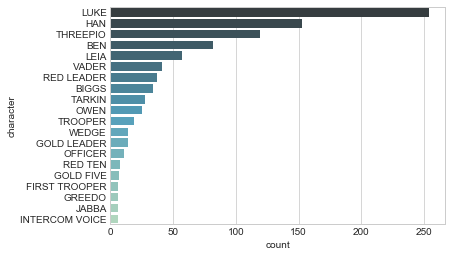

In [13]:
character_count(SW_IV)

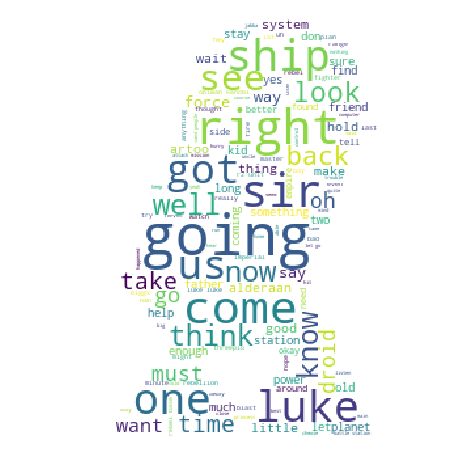

In [14]:
SWCloud(SW_IV, 'img/r2d2.png', 'IV')

&emsp;&emsp;接着是**帝国反击战**，在这一集中，爵爷对卢克说出了那句著名的 *"I’m your father"*。

character
HAN             182
LUKE            128
LEIA            114
THREEPIO         92
LANDO            61
VADER            56
YODA             36
PIETT            23
CREATURE         21
BEN              15
RIEEKAN          13
WEDGE             8
DECK OFFICER      7
VEERS             7
ZEV               6
EMPEROR           5
OZZEL             5
NEEDA             5
JANSON            4
DACK              4
dtype: int64


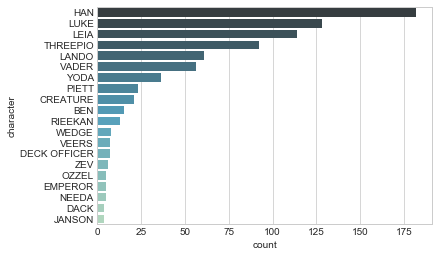

In [15]:
character_count(SW_V)

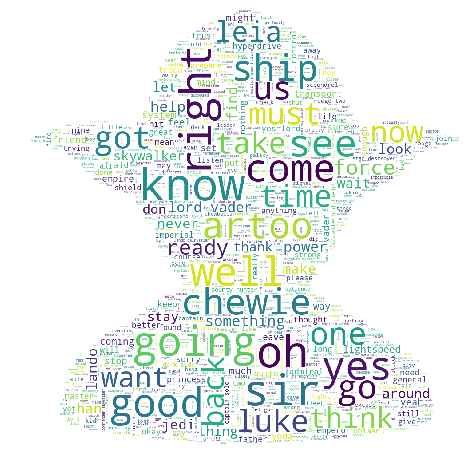

In [16]:
SWCloud(SW_V, 'img/yoda.png', 'V')

&emsp;&emsp;最后是**绝地归来**，在这集中，由于爵爷堕入原力的光明面，加上帝国没钱造栏杆，叛军取得胜利，并承胜追击，占领了帝国大半的领土，在此危急存亡之秋，索龙元帅脱颖而出...

character
HAN             124
LUKE            112
THREEPIO         90
LEIA             56
VADER            43
LANDO            40
EMPEROR          39
JABBA            20
BEN              18
ACKBAR           14
YODA             13
WEDGE            11
PIETT             8
BOUSHH            7
COMMANDER         7
JERJERROD         7
STORMTROOPER      6
BIB               6
NINEDENINE        6
CONTROLLER        5
dtype: int64


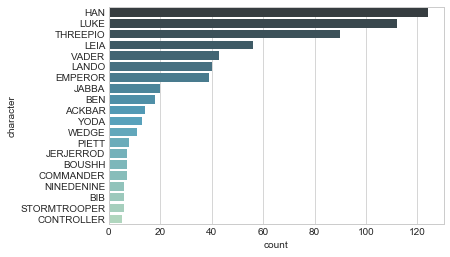

In [17]:
character_count(SW_VI)

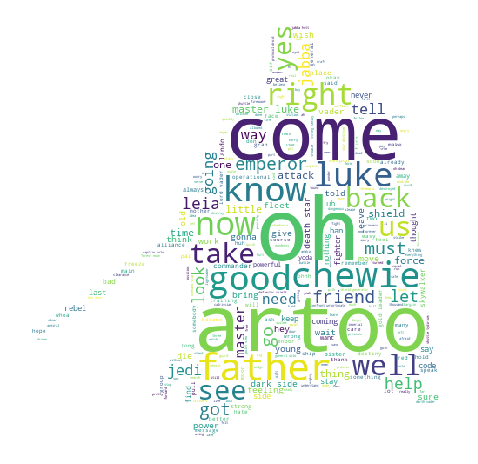

In [18]:
SWCloud(SW_VI, 'img/vader.jpg', 'VI')

&emsp;&emsp;在正传三部曲中，台词最多的无疑是男主卢克天行者，其次是戏份一点也不比男主少的汉·索罗，而话痨 C-3PO 则屈居探花。为广大人民群众所喜闻乐见的楚巴卡和 R2-D2，由于只会发出奇怪的声音，只能活在台词中了。

character
LUKE           494
HAN            459
THREEPIO       301
LEIA           227
VADER          140
BEN            115
LANDO          101
YODA            49
EMPEROR         44
RED LEADER      38
BIGGS           34
WEDGE           33
PIETT           31
TARKIN          28
JABBA           26
OWEN            25
CREATURE        22
TROOPER         19
GOLD LEADER     14
ACKBAR          14
dtype: int64


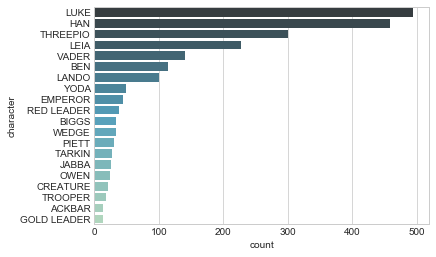

In [19]:
character_count(SW)

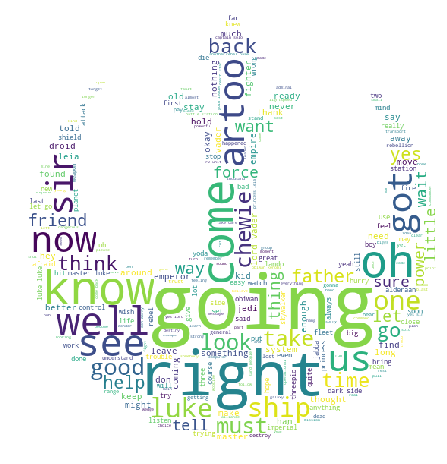

In [20]:
SWCloud(SW, 'img/rebel alliance.png')

## 5 TF-IDF

&emsp;&emsp;再看看叛军是否使用与帝国不同的词语。这里为了方便起见，将次要角色归为 3 类，分别是帝国（Rebels）、叛军（Rebels）和中立（Neutrals），以**新希望**为例。

In [21]:
def character_group(name: str) -> str:
    """
        将次要角色归类
        
        Args:
            name: string, character name
            
        Returns:
            string, main character name & secondary character type
    """
    rebel = ('BASE VOICE', 'CONTROL OFFICER', 'MAN', 'PORKINS', 'REBEL OFFICER', 'RED ELEVEN',
             'RED TEN', 'RED SEVEN', 'RED NINE', 'RED LEADER', 'BIGGS', 'GOLD LEADER',
             'WEDGE', 'GOLD FIVE', 'REBEL', 'DODONNA', 'CHIEF', 'TECHNICIAN', 'WILLARD',
             'GOLD TWO', 'MASSASSI INTERCOM VOICE')
    imperial = ('CAPTAIN', 'CHIEF PILOT', 'TROOPER', 'OFFICER', 'DEATH STAR INTERCOM VOICE',
                'FIRST TROOPER', 'SECOND TROOPER', 'FIRST OFFICER', 'OFFICER CASS', 
                'INTERCOM VOICE', 'MOTTI', 'TAGGE', 'TROOPER VOICE', 'ASTRO-OFFICER',
                'VOICE OVER DEATH STAR INTERCOM', 'SECOND OFFICER', 'GANTRY OFFICER', 
                'WINGMAN', 'IMPERIAL OFFICER', 'COMMANDER', 'VOICE')
    neutral = ('WOMAN', 'BERU', 'CREATURE', 'DEAK', 'OWEN', 'BARTENDER', 'CAMIE', 'JABBA', 
               'AUNT BERU', 'GREEDO', 'NEUTRAL', 'HUMAN', 'FIXER')

    if name in rebel:
        return 'Rebels'
    elif name in imperial:
        return 'Imperials'
    elif name in neutral:
        return 'Neutrals'
    else:
        return name

group_character
LUKE         254
HAN          153
Rebels       139
THREEPIO     119
BEN           82
Imperials     79
Neutrals      58
LEIA          57
VADER         41
TARKIN        28
dtype: int64


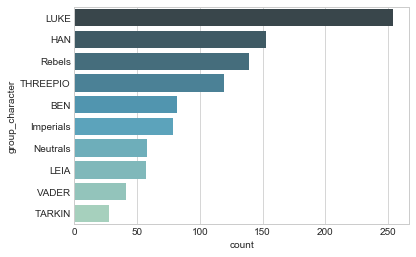

In [22]:
SW_IV['group_character'] = SW_IV['character'].apply(character_group)
    
print(SW_IV.groupby('group_character').size().sort_values(ascending=False))
    
sns.countplot(y="group_character", data=SW_IV, 
            palette="GnBu_d", 
            order = SW_IV['group_character'].value_counts().index);

&emsp;&emsp;通过 **TF-IDF** 方法提取相关单词，每个单词将在每一行中都有一个值，表示其重要性。

In [23]:
tfidf_vec = TfidfVectorizer(max_df=0.1, max_features=200, stop_words='english')

features = tfidf_vec.fit_transform(SW_IV['dialogue'])
X = pd.DataFrame(data=features.toarray(), 
                 index=SW_IV.group_character, 
                 columns=tfidf_vec.get_feature_names())
X.sample(10)

,able,aboard,academy,afraid,alderaan,artoo,attack,away,bad,base,...,wasn,watch,way,won,wonder,work,worry,yeah,year,yes
group_character,,,,,,,,,,,,,,,,,,,,,
LUKE,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.498227,0.000000,0.0,0.0,0.0,0.0
LEIA,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
LEIA,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
TARKIN,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
HAN,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
TARKIN,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
THREEPIO,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
Rebels,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
BEN,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


&emsp;&emsp;使用 **PCA** 将每一行显示在 2D 图形中。

In [24]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

df_reduced = pd.DataFrame(X_reduced)
df_reduced['group_character'] = X.index
df_reduced.head(10)

,0,1,group_character
0,-0.184822,0.028819,THREEPIO
1,-0.002174,-0.025090,THREEPIO
2,-0.214151,0.074000,THREEPIO
3,-0.002174,-0.025090,THREEPIO
4,-0.029666,-0.017210,THREEPIO
5,0.128734,0.008012,LUKE
6,0.032040,-0.023725,THREEPIO
7,-0.002174,-0.025090,THREEPIO
8,-0.186961,0.776153,THREEPIO
9,0.129600,0.525136,THREEPIO


&emsp;&emsp;为角色分配对应的颜色：
- 叛军中的中坚分子显示为蓝色；
- 叛军中的其他人员显示为青色；
- 爵爷显示为红色；
- 其他帝国成员为洋红；
- 中立设为黑色。

In [25]:
def character_to_color(name: str):
    """
        返回角色对应的颜色
    
        Args:
            name: string
    
        Returns:
            Series
    """
    color = {'LUKE': 'b', 'HAN': 'b', 'THREEPIO': 'b', 'BEN': 'b', 'LEIA': 'b',
             'VADER': 'r', 'TARKIN': 'r', 
             'Imperials': 'm', 'Rebels': 'c', 'Neutrals': 'k'}
    return color[name]

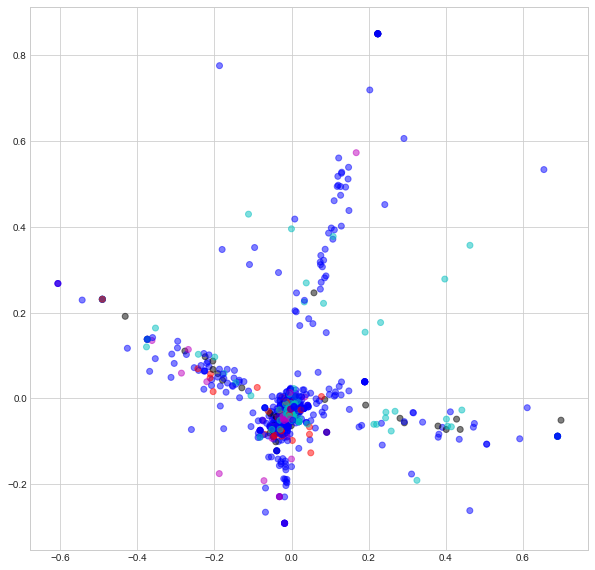

In [26]:
df_reduced['color'] = df_reduced['group_character'].apply(character_to_color)

plt.figure(figsize=(10, 10))
plt.scatter(x=df_reduced[0], y=df_reduced[1],
            color=df_reduced['color'], alpha=0.5)
plt.savefig('output\displaying_lines.jpg');

&emsp;&emsp;不难看出，蓝色和青色广泛地分布在平面上，而红色和洋红则主要集中在左侧靠下的位置，这意味着叛军使用的词汇比帝国要广泛。

&emsp;&emsp;值得注意的是，在上方有一点洋红色，“我们中出了一个叛徒”，将这点找出来！

In [27]:
df_reduced[(df_reduced[0]>0.1) & (df_reduced[1]>0.55) & (df_reduced[1]<0.6)]

,0,1,group_character,color
646,0.122418,0.560791,HAN,b
714,0.167888,0.573151,Imperials,m


In [28]:
SW_IV.loc[714]

character                     FIRST TROOPER
dialogue           Give me regular reports.
clean_text         [give, regular, reports]
group_character                   Imperials
Name: 714, dtype: object

## 6 Word2Vec

&emsp;&emsp;使用 `gensim` 构建 **Word2Vec**。

In [29]:
sentences_IV = SW_IV['clean_text']

model = gensim.models.Word2Vec(min_count=3, window=5, iter=20)
model.build_vocab(sentences_IV)
model.train(sentences_IV, total_examples=model.corpus_count, epochs=model.epochs)

(84136, 142920)

&emsp;&emsp;Word2Vec 为语料库中的每个单词构建一个向量，可以籍此讨论不同单词的接近程度——相似的词具有接近1的值，而相反的词具有接近-1的值。

In [30]:
model.wv.most_similar('force')

E:\IDE\Anaconda3\envs\gaius\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('system', 0.9998038411140442),
 ('he', 0.9998025298118591),
 ('the', 0.9997953176498413),
 ('us', 0.9997825622558594),
 ('going', 0.9997814893722534),
 ('want', 0.9997798800468445),
 ('her', 0.9997773170471191),
 ('main', 0.9997760057449341),
 ('get', 0.9997740983963013),
 ('one', 0.9997738599777222)]

In [31]:
model.wv.most_similar(negative=['force'])

E:\IDE\Anaconda3\envs\gaius\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('hello', -0.992935836315155),
 ('makes', -0.9964836239814758),
 ('worse', -0.9966601133346558),
 ('artoodetoo', -0.9969137907028198),
 ('moving', -0.9970685839653015),
 ('identification', -0.9971023797988892),
 ('rock', -0.9971140027046204),
 ('gonna', -0.9974701404571533),
 ('cover', -0.9974837899208069),
 ('over', -0.9975569248199463)]

&emsp;&emsp;创建一个关于主要角色的词汇列表。

In [32]:
characters = SW_IV['group_character'].str.lower().unique()

In [33]:
vocab = list(model.wv.vocab)
vocab = list(filter(lambda x: x in characters, vocab))
vocab

['vader', 'luke', 'ben', 'threepio', 'han', 'leia', 'tarkin']

&emsp;&emsp;创建一个表示词汇的向量列表。

In [34]:
X = model[vocab]

E:\IDE\Anaconda3\envs\gaius\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


&emsp;&emsp;通过 **K-Means** 算法将数据以 3 个簇为中心进行聚类。

In [35]:
cluster_num = 3

kmeans = KMeans(n_clusters=cluster_num, random_state=0).fit(X)
cluster = kmeans.predict(X)

&emsp;&emsp;使用PCA来降低到2维，再将其可视化。

In [36]:
pca = PCA(n_components=2, random_state=11, whiten=True)
clf = pca.fit_transform(X)

tmp = pd.DataFrame(clf, index=vocab, columns=['x', 'y'])

tmp.head(3)

,x,y
vader,-1.250627,-0.234680
luke,-0.518155,-0.382818
ben,-0.040093,-0.342223


E:\IDE\Anaconda3\envs\gaius\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\IDE\Anaconda3\envs\gaius\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


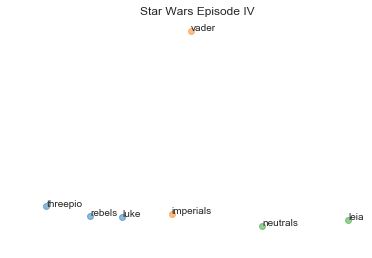

In [37]:
tmp['cluster'] = None
tmp['c'] = None

count = 0
for index, row in tmp.iterrows():
    tmp['cluster'][index] = cluster[count]
    tmp['c'][index] = characters[count]
    count += 1
    
for i in range(cluster_num):
    values = tmp[tmp['cluster'] == i]
    plt.scatter(values['x'], values['y'], alpha = 0.5)

for word, row in tmp.iterrows():
    x, y, cat, character = row
    pos = (x, y)
    plt.annotate(character, pos)
    
plt.axis('off')
plt.title('Star Wars Episode IV')
plt.savefig('output\w2v_map.jpg')
plt.show();